# Similarity.py

In [1]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys
import os
import re

In [2]:
#folder with data files
path = "/home/sasha/Desktop/TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/"
files = os.listdir(path)

In [3]:
#load csv files into dictionary

#create a regex to parse file names
pattern = re.compile("""TiNiSn_500C_Y20190218_14x14_t60_
                         (?P<num>.*?)
                         _bkgdSub_1D.csv""", re.VERBOSE)

#read files and create dictionary
#data maps: cell number -> csv data
data ={}
for file in files:
    match = pattern.match(file)
    if(match == None):
        continue
    num = int(match.group("num"))
    data[num] = np.array(pd.read_csv(path + file,header=None))

print("data in grid cell 3:")
data[3]

data in grid cell 3:


array([[ 1.50250007, 14.09118183],
       [ 1.50750007, 15.38790799],
       [ 1.51250007, 16.71735611],
       ...,
       [ 5.48750064, 26.67669137],
       [ 5.49250064, 32.62816851],
       [ 5.49750064, 39.90884715]])

In [4]:
# specific values in the grid
row_sums = [5, 14, 25, 38, 51, 66, 81, 96, 111, 126, 139, 152, 163, 172, 177]
row_starts = [1] + [x + 1 for x in row_sums[:-1]]
row_lengths = [5,9,11,13,13,15,15,15,15,15,13,13,11,9,5]
base_vals = [52,26,15,6,7,1,2,3,4,5,13,14,25,38,66]
top_vals = [112,140,153,164,165,173,174,175,176,177,171,172,163,152,126]

In [5]:
# define neighbors function to get neighbors of specific tiles
def get_row(d):
    return next(i for i,s in enumerate(row_sums) if d-s <= 0) + 1
def up_shift(d):
    return (row_lengths[get_row(d)] + row_lengths[get_row(d)-1])//2
def down_shift(d):
    return (row_lengths[get_row(d)-2] + row_lengths[get_row(d)-1])//2

def neighbors(d):
    neighbor_dict = {}
    if d not in row_starts: #left neighbor
        neighbor_dict['left'] = d-1
    if d not in row_sums:   #right neighbor
        neighbor_dict['right'] = d+1
    if d not in top_vals: #up neighbor
        neighbor_dict['up'] = d + up_shift(d)
    if d not in base_vals: #down neighbor
        neighbor_dict['down'] = d - down_shift(d)
    return neighbor_dict

print("neighbors of cell 111")
neighbors(111)

neighbors of cell 111


{'left': 110, 'up': 126, 'down': 96}

In [6]:
# function to get grid location from the grid location number
def coord(d):
    y = get_row(d)
    pos_in_row = d
    if y > 1:
        pos_in_row = d - row_sums[y-2]
    x = 8 - (row_lengths[y-1]+1)//2 + pos_in_row
    return x,y

In [7]:
#similarity metric
def similarity(d1,d2):
    a = data[d1][:,1]
    b = data[d2][:,1]
    return np.dot(a,b)/np.linalg.norm(a)/np.linalg.norm(b)

In [8]:
#create grid
grid = np.zeros(shape=(15,15))

In [9]:
#calculate similarity values for grid
for val in range(1,177):
    x,y = coord(val)
    #which neighbors are used for similarity calculation
    #keys = ['up','left']
    keys = ['up', 'left', 'right', 'down']
    neigh = [neighbors(val)[k] for k in neighbors(val).keys() if k in keys]
    sim_values = [similarity(val,x) for x in neigh]
    if len(sim_values) == 0:
        grid[x-1][y-1] = 1
        continue
    grid[x-1][y-1] = np.amin(sim_values)


In [10]:
#normalize grid based on min
# values range (0, max - min]
#this shows the relitive similarity values
min = np.min(grid.ravel()[np.nonzero(grid.ravel())])
min_array = np.full(grid.shape,min*.99)
grid = np.clip(grid - min_array,0,1)

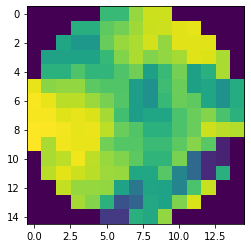

In [11]:
#show similarity plot
plt.imshow(grid)
plt.show()